In [1]:
from pymatgen.io.vasp import Poscar, Xdatcar
from pymatgen.symmetry.groups import SpaceGroup
import numpy as np
from site_analysis.atom import Atom, atoms_from_species_string
from site_analysis.trajectory import Trajectory
from site_analysis.polyhedral_site import PolyhedralSite
from site_analysis.tools import get_nearest_neighbour_indices
from collections import Counter
import tqdm
import matplotlib.pyplot as plt

In [2]:
directory = '../../data'
structure = Poscar.from_file(f'{directory}/reference_structures/Li6PS5I_alltet_sites.POSCAR.vasp').structure

In [3]:
from pymatgen import Structure
lattice = structure.lattice
t0 = Structure.from_spacegroup(sg='F-43m', lattice=lattice, species=['P'], coords=[[0.5, 0.0, 0.0]])
t1 = Structure.from_spacegroup(sg='F-43m', lattice=lattice, species=['Li'], coords=[[0.9, 0.9, 0.6]])
t2 = Structure.from_spacegroup(sg='F-43m', lattice=lattice, species=['Li'], coords=[[0.23, 0.92, 0.08]])
t3 = Structure.from_spacegroup(sg='F-43m', lattice=lattice, species=['Li'], coords=[[0.25, 0.25, 0.25]])
t4 = Structure.from_spacegroup(sg='F-43m', lattice=lattice, species=['Li'], coords=[[0.15, 0.15, 0.15]])
t5 = Structure.from_spacegroup(sg='F-43m', lattice=lattice, species=['Li'], coords=[[0.0, 0.183, 0.183]])
tet_sites = [t0, t1, t2, t3, t4, t5]

In [4]:
s_sites = Structure.from_spacegroup(sg='F-43m', 
                                    lattice=lattice,
                                    species=['S', 'S', 'S'], 
                                    coords=[[0.0, 0.0, 0.0],
                                            [0.75, 0.25, 0.25],
                                            [0.11824, 0.11824, 0.38176]])*[2,2,2]

In [5]:
def map_to_nearest_site(input_structure, species_strings, ref_structure, verbose=True):
    mappings = []
    site_indices = [i for i, s in enumerate(input_structure) if s.species_string in species_strings]
    sites = [input_structure[i] for i in site_indices]
    frac_coords = [input_structure[i].frac_coords for i in site_indices]
    latt = ref_structure.lattice
    dr = latt.get_all_distances( frac_coords, ref_structure.frac_coords )
    disp = []
    for s, r in zip(sites, dr):
        index = np.argmin(r)
        mappings.append(index)
        disp.append(latt.get_distance_and_image(s.frac_coords, ref_structure[index].frac_coords)[0])
        s.coords = ref_structure[index].coords
        assert(len(mappings) == len(set(mappings)))
    if verbose:
        print(f'max mapping displacement = {max(disp)}')

In [6]:
def tetrahedral_site_trajectory( xdatcar, x_spec ):
    md_structure = xdatcar.structures[0]
    map_to_nearest_site(md_structure, ['S', x_spec], s_sites)
    atoms = atoms_from_species_string(md_structure, 'Li')

    t0_indices = get_nearest_neighbour_indices(md_structure, t0*[2,2,2], vertex_species=['S', x_spec], n_coord=4)
    t1_indices = get_nearest_neighbour_indices(md_structure, t1*[2,2,2], vertex_species=['S', x_spec], n_coord=4)
    t2_indices = get_nearest_neighbour_indices(md_structure, t2*[2,2,2], vertex_species=['S', x_spec], n_coord=4)
    t3_indices = get_nearest_neighbour_indices(md_structure, t3*[2,2,2], vertex_species=['S', x_spec], n_coord=4)
    t4_indices = get_nearest_neighbour_indices(md_structure, t4*[2,2,2], vertex_species=['S', x_spec], n_coord=4)
    t5_indices = get_nearest_neighbour_indices(md_structure, t5*[2,2,2], vertex_species=['S', x_spec], n_coord=4)
    
    PolyhedralSite.reset_index()

    t0_sites = PolyhedralSite.sites_from_vertex_indices(t0_indices, label='0')
    t1_sites = PolyhedralSite.sites_from_vertex_indices(t1_indices, label='1')
    t2_sites = PolyhedralSite.sites_from_vertex_indices(t2_indices, label='2')
    t3_sites = PolyhedralSite.sites_from_vertex_indices(t3_indices, label='3')
    t4_sites = PolyhedralSite.sites_from_vertex_indices(t4_indices, label='4')
    t5_sites = PolyhedralSite.sites_from_vertex_indices(t5_indices, label='5') 

    sites = t0_sites + t1_sites + t2_sites + t3_sites + t4_sites + t5_sites

    trajectory = Trajectory(atoms=atoms, sites=sites)
    trajectory.trajectory_from_structures( xdatcar.structures, progress='notebook')
    return trajectory

def site_populations(trajectory):
    c = Counter()
    for site in trajectory.sites:
        c[site.label] += len([ 1 for ts in site.trajectory if len(ts)>0 ])
    total = sum(c.values())
    return {label: n/total for label, n in c.items()}

In [7]:
populations = {'Li6PS5I': {}, 'Li6PS5Cl': {}}
transitions = {'Li6PS5I': {}, 'Li6PS5Cl': {}}

In [8]:
def site_transitions(analysis):
    unassignable = 0
    transitions = {'1': Counter({'1':0, '2':0, '3':0, '4':0, '5':0}),
                   '2': Counter({'1':0, '2':0, '3':0, '4':0, '5':0}),
                   '3': Counter({'1':0, '2':0, '3':0, '4':0, '5':0}), 
                   '4': Counter({'1':0, '2':0, '3':0, '4':0, '5':0}), 
                   '5': Counter({'1':0, '2':0, '3':0, '4':0, '5':0})}
    for atom_trajectory in np.array(analysis.atoms_trajectory).T:
        for i, j in zip(atom_trajectory[:-1], atom_trajectory[1:]):
            if i != j:
                site_i = analysis.site_by_index(i)
                site_j = analysis.site_by_index(j)
                neighbouring_sites = analysis.site_collection.neighbouring_sites(i)
                if site_j.index in [ s.index for s in neighbouring_sites ]:
                    transitions[site_i.label][site_j.label] += 1
                else:
                    n_sites_i = analysis.site_collection.neighbouring_sites(i)
                    n_sites_j = analysis.site_collection.neighbouring_sites(j)
                    intermediate_site = set([s.index for s in n_sites_i]) & set([s.index for s in n_sites_j])
                    if len(intermediate_site) == 1:
                        site_int = analysis.site_by_index(list(intermediate_site)[0])
                        transitions[site_i.label][site_int.label] += 1
                        transitions[site_int.label][site_j.label] += 1
                    else:
                        unassignable += 1
    print(f'{unassignable} changes not assigned')
    return transitions

In [9]:
system = 'Li6PS5I'
disorder = '0p'
x_spec = 'I'
xdatcar = Xdatcar(f'{directory}/{system}/{disorder}/run1/inherent_XDATCAR.gz')
trajectory = tetrahedral_site_trajectory( xdatcar, x_spec )
populations[system][disorder] = site_populations(trajectory)
transitions[system][disorder] = site_transitions(trajectory)

max mapping displacement = 0.2557492206222053



0 changes not assigned


In [10]:
system = 'Li6PS5I'
disorder = '50p'
x_spec = 'I'
xdatcar = Xdatcar(f'{directory}/{system}/{disorder}/run1/inherent_XDATCAR.gz')
trajectory = tetrahedral_site_trajectory( xdatcar, x_spec )
populations[system][disorder] = site_populations( trajectory )
transitions[system][disorder] = site_transitions(trajectory)

max mapping displacement = 0.5849922354277903



2 changes not assigned


In [11]:
system = 'Li6PS5I'
disorder = '100p'
x_spec = 'I'
xdatcar = Xdatcar(f'{directory}/{system}/{disorder}/run1/inherent_XDATCAR.gz')
trajectory = tetrahedral_site_trajectory( xdatcar, x_spec )
populations[system][disorder] = site_populations( trajectory )
transitions[system][disorder] = site_transitions(trajectory)

max mapping displacement = 0.4270758927802738



0 changes not assigned


In [12]:
system = 'Li6PS5Cl'
disorder = '0p'
x_spec = 'Cl'
xdatcar = Xdatcar(f'{directory}/{system}/{disorder}/run1/inherent_XDATCAR.gz')
trajectory = tetrahedral_site_trajectory( xdatcar, x_spec )
populations[system][disorder] = site_populations( trajectory )
transitions[system][disorder] = site_transitions(trajectory)

max mapping displacement = 0.8905481681525752



7 changes not assigned


In [13]:
system = 'Li6PS5Cl'
disorder = '50p'
x_spec = 'Cl'
xdatcar = Xdatcar(f'{directory}/{system}/{disorder}/run1/inherent_XDATCAR.gz')
trajectory = tetrahedral_site_trajectory( xdatcar, x_spec )
populations[system][disorder] = site_populations( trajectory )
transitions[system][disorder] = site_transitions(trajectory)

max mapping displacement = 0.7812197665560381



12 changes not assigned


In [14]:
system = 'Li6PS5Cl'
disorder = '100p'
x_spec = 'Cl'
xdatcar = Xdatcar(f'{directory}/{system}/{disorder}/run1/inherent_XDATCAR.gz')
trajectory = tetrahedral_site_trajectory( xdatcar, x_spec )
populations[system][disorder] = site_populations( trajectory )
transitions[system][disorder] = site_transitions(trajectory)

max mapping displacement = 0.6035455650682233



8 changes not assigned


In [33]:
def get_data(st):
    data = np.array([[st['2']['2'], st['4']['2'], st['5']['2']],
                     [st['2']['4'], st['4']['4'], st['5']['4']],
                     [st['2']['5'], st['4']['5'], st['5']['5']]])
    data = data / data.sum(axis=0)
    return data.T # following right stochastic matrix convention: https://en.wikipedia.org/wiki/Stochastic_matrix

In [34]:
import matplotlib as mpl


def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, vmin=0.0, vmax=1.0, **kwargs)

#     # Create colorbar
#     cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
#     cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

#     # Turn spines off and create white grid.
#     for edge, spine in ax.spines.items():
#         spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if data[i,j] > 0:
                if np.ma.is_masked(data):
                    if not data.mask[i,j]:
                        kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
                        text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
                        texts.append(text)
                else:
                    kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
                    text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
                    texts.append(text)
    return texts

/Users/bjm42/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


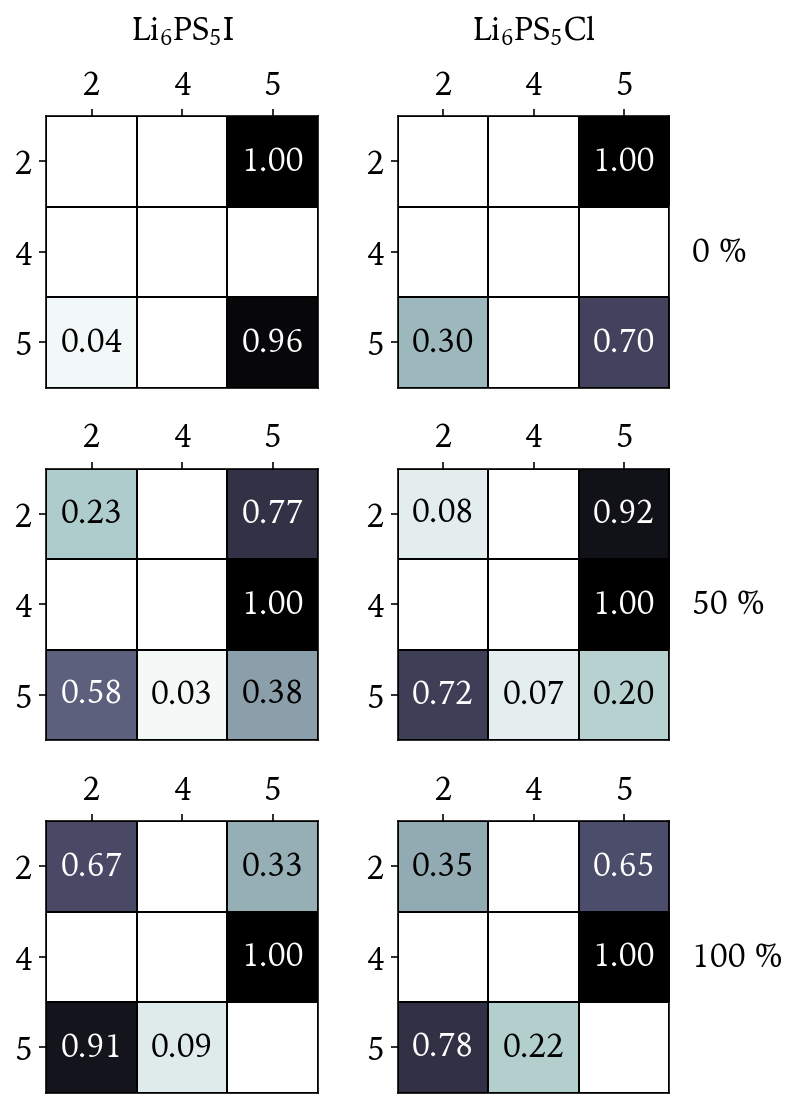

In [35]:
from matplotlib import rcParams

rcParams['font.serif'] = "Iowan Old Style"
rcParams['font.family'] = "serif"

rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Iowan Old Style'
rcParams['mathtext.it'] = 'Iowan Old Style:italic'
rcParams['mathtext.bf'] = 'Iowan Old Style:bold'

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams.update({'font.size': 16})

cmap = "bone_r"
sites = [2,4,5]
fig, ax = plt.subplots(3,2, figsize=(5.9,8))

data = get_data(transitions['Li6PS5I']['0p'])
im = heatmap(data, sites, sites, ax=ax[0,0],
                   cmap=cmap, cbarlabel=r"$P_\mathrm{trans}$")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

data = get_data(transitions['Li6PS5Cl']['0p'])
im = heatmap(data, sites, sites, ax=ax[0,1],
                   cmap=cmap, cbarlabel=r"$P_\mathrm{trans}$")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

data = get_data(transitions['Li6PS5I']['50p'])

im = heatmap(data, sites, sites, ax=ax[1,0],
                   cmap=cmap, cbarlabel=r"$P_\mathrm{trans}$")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

data = get_data(transitions['Li6PS5Cl']['50p'])
im = heatmap(data, sites, sites, ax=ax[1,1],
                   cmap=cmap, cbarlabel=r"$P_\mathrm{trans}$")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

data = get_data(transitions['Li6PS5I']['100p'])
im = heatmap(data, sites, sites, ax=ax[2,0],
                   cmap=cmap, cbarlabel=r"$P_\mathrm{trans}$")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

data = get_data(transitions['Li6PS5Cl']['100p'])
im = heatmap(data, sites, sites, ax=ax[2,1],
                   cmap=cmap, cbarlabel=r"$P_\mathrm{trans}$")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

ax[0,0].set_title(r'Li$_6$PS$_5$I', pad=15, size=16)
ax[0,1].set_title(r'Li$_6$PS$_5$Cl', pad=15, size=16)
ax[0,1].text(2.75,1.1,'0 %')
ax[1,1].text(2.75,1.1,'50 %')
ax[2,1].text(2.75,1.1,'100 %')

fig.tight_layout()
plt.savefig('../../figures/transition_matrices.pdf')
plt.show()